# LSTM  + ElMO

En esta, rehacemos todo lo de ElMO pero usando nuestra nueva clase: ElMOModel

In [2]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/test_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Tengo que hacer dos cosas:

- Primero, convertir los tweets a secuencias de texto
- Luego, paddear las secuencias a cierta longitud (Keras necesita esto para poder paralelizar cálculo)

In [3]:
from hate.nn.preprocessing import Tokenizer

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

tokenizer = Tokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

tokens_train = [tokenizer.tokenize(tweet) for tweet in df_train["text"].values]
tokens_dev = [tokenizer.tokenize(tweet) for tweet in df_dev["text"].values]
tokens_test = [tokenizer.tokenize(tweet) for tweet in df_test["text"].values]

Using TensorFlow backend.


Veamos las distribuciones de las longitudes de tokens

Media de longitud: train 22.91 dev 23.33 test 23.33


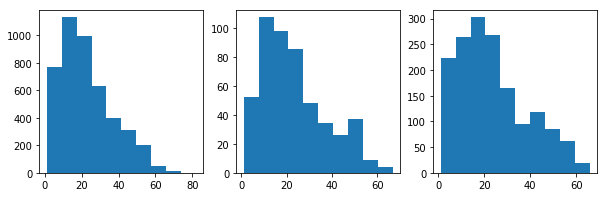

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,3)

train_lens = np.array([len(t) for t in tokens_train]) 
dev_lens = np.array([len(t) for t in tokens_dev])
test_lens = np.array([len(t) for t in tokens_test])

plt.subplot(1, 3, 1)

plt.hist(train_lens)

plt.subplot(1, 3, 2)
plt.hist(dev_lens)

plt.subplot(1, 3, 3)
plt.hist(test_lens)

print("Media de longitud: train {:.2f} dev {:.2f} test {:.2f}".format(train_lens.mean(), dev_lens.mean(), test_lens.mean()))


(array([ 52., 107.,  98.,  85.,  48.,  34.,  26.,  37.,   9.,   4.]),
 array([ 1. ,  7.6, 14.2, 20.8, 27.4, 34. , 40.6, 47.2, 53.8, 60.4, 67. ]),
 <a list of 10 Patch objects>)

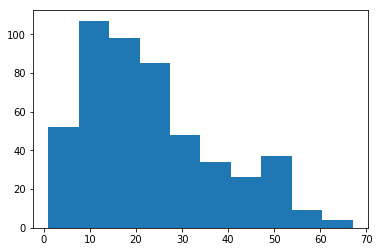

In [5]:
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_dev])

In [14]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

2019-01-19 23:15:30,432 INFO: char embedding size: 2637
2019-01-19 23:15:32,608 INFO: word embedding size: 185214
2019-01-19 23:15:43,247 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(185214, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2637, 50, padding_idx=2634)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

Carguemos embeddings

In [17]:
from hate.nn import ElmoModel
from keras.optimizers import Adam

embedding_dim = 1024

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

max_len = 60

X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]

model = ElmoModel(max_len=60, embedder=e, tokenize_args=tokenize_args)

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=20, batch_size=32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo_Input (InputLayer)      (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               1180672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_elmo (Dense)           (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 1,213,697
Trainable params: 1,213,697
Non-trainable params: 0
_________________________________________________________________
None


2019-01-19 23:20:09,402 INFO: 71 batches, avg len: 62.0


KeyboardInterrupt: 

In [7]:
from hate.utils import print_evaluation

print_evaluation(model, X_dev, y_dev)

500/500 [==============================] - 0s 679us/step
Loss        : 0.4876
Accuracy    : 0.7740
Precision   : 0.7401
Recall      : 0.7568
F1          : 0.7483


## Bidirectional GRU

In [9]:
y_train.shape

(4500,)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

embedding_dim = 1024

model = Sequential()
model.add(Bidirectional(GRU(256, input_shape=(max_length, embedding_dim))))
model.add(Dropout(0.80))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=25, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/25
4500/4500 [==============================] - 12s 3ms/step - loss: 0.8192 - acc: 0.5482 - val_loss: 0.6684 - val_acc: 0.5880
Epoch 2/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.7269 - acc: 0.5836 - val_loss: 0.6510 - val_acc: 0.6400
Epoch 3/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.6674 - acc: 0.6291 - val_loss: 0.6370 - val_acc: 0.6720
Epoch 4/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.6506 - acc: 0.6471 - val_loss: 0.6305 - val_acc: 0.6680
Epoch 5/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.6311 - acc: 0.6547 - val_loss: 0.6102 - val_acc: 0.7020
Epoch 6/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.6005 - acc: 0.6802 - val_loss: 0.5947 - val_acc: 0.7100
Epoch 7/25
4500/4500 [==============================] - 10s 2ms/step - loss: 0.5812 - acc: 0.6976 - val_loss: 0.5789 - val_acc: 0.7260
Epoch 8/

In [17]:
model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=2, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3734 - acc: 0.8387 - val_loss: 0.4570 - val_acc: 0.7960
Epoch 2/2
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3666 - acc: 0.8333 - val_loss: 0.4473 - val_acc: 0.7960


In [18]:
model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=3, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3636 - acc: 0.8418 - val_loss: 0.4557 - val_acc: 0.7900
Epoch 2/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3614 - acc: 0.8422 - val_loss: 0.4525 - val_acc: 0.7920
Epoch 3/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3607 - acc: 0.8436 - val_loss: 0.4424 - val_acc: 0.8020


In [19]:
model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=3, batch_size=32)

Train on 4500 samples, validate on 500 samples
Epoch 1/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3524 - acc: 0.8413 - val_loss: 0.4523 - val_acc: 0.7980
Epoch 2/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3431 - acc: 0.8556 - val_loss: 0.4505 - val_acc: 0.7980
Epoch 3/3
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3403 - acc: 0.8538 - val_loss: 0.4456 - val_acc: 0.8000


In [20]:
from hate.utils import print_evaluation

print_evaluation(model, X_dev, y_dev)

500/500 [==============================] - 1s 1ms/step
Loss        : 0.4456
Accuracy    : 0.8000
Precision   : 0.7675
Recall      : 0.7883
F1          : 0.7778


## Error Analysis

Vamos a ver los tweets con mayores errores

In [21]:
df_dev["proba"] = model.predict_proba(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

conf_matrix[["pred_true", "pred_false"]]

,pred_true,pred_false
real,,
hs=1,175,47
hs=0,53,225


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [29]:
false_negatives.iloc[:20]


,text,HS,TR,AG,proba
id,,,,,
21535,#VOX critica duramente a ⁦@pablocasado_⁩ “Les da la bienvenida como si fuera un cartel del welcome de #Carmena “ ¡Expulsión inmediata de moromierdas! https://t.co/HaySDibj2l,1,0,1,0.043542
21152,@NatyBurgos15 @Horaciogenta @PaolaPa05 Cállate vos Black and bitch como la puta falsa abogada. Espero se pudra en la cárcel y devuelva todo. Dedícate a estudiar en serio. La droga es mala. Cristin...,1,1,1,0.053808
22560,@CarlaEUrena @FelipeCalderon Callateeeee !! Puta gallina cacarea !! Ni idea tienes de nada .,1,1,1,0.080199
23415,Exacto! #puralata #feminazis #HombreAbusado https://t.co/zTEvaftxcd,1,0,1,0.084722
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",1,1,1,0.092792
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",1,0,0,0.144993
24401,No habrá que darles de lo 'nuestro'. Ellos se apropiarán de lo 'suyo'. @Manuj_Hidalgo les dice ☝️ a quienes piensan q hay q jubilar a los mayores para q trabajen los jóvenes o q los q vienen d fu...,1,0,1,0.151047
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para ...",1,0,1,0.152465
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",1,1,1,0.157015


- Qué onda la longitud de la secuencia?


(array([ 734., 1109., 1019.,  655.,  386.,  315.,  210.,   57.,   13.,
           2.]),
 array([ 2., 10., 18., 26., 34., 42., 50., 58., 66., 74., 82.]),
 <a list of 10 Patch objects>)

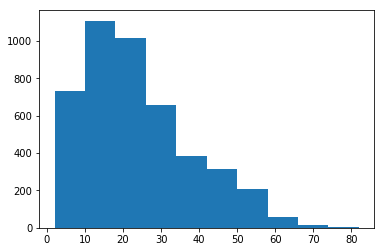

In [39]:
import matplotlib.pyplot as plt

tokens_dev = df_dev["text"].apply(lambda t: len(tokenizer.tokenize(t)))
tokens_train = df_train["text"].apply(lambda t: len(tokenizer.tokenize(t)))

plt.hist(tokens_train)

In [28]:
pd.set_option('max_colwidth', 200)
false_positives.iloc[:20]

,text,HS,TR,AG,proba
id,,,,,
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0,0,0,0.971048
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0,0,0,0.967200
21892,@saancisco Callate puta tu eres el traidor.,0,0,0,0.963039
21497,Talvez quede como zorra pero te lo mereces Socia😎,0,0,0,0.947185
24172,"Y los que no se denuncian... hagamos números. El acoso a las mujeres es diario. No todos los hombres son acosadores, pero todas las mujeres han sido acosadas. https://t.co/jza9llhqWA",0,0,0,0.945128
21255,Y tú eres una maldita escoria con una repugnante inclinación por los hombres.. ¡Seres como tú me producen náuseas! https://t.co/TaHDcpZdnm,0,0,0,0.943286
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0,0,0,0.931898
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0,0,0,0.925799
21671,"@danlntifada @fatinascidi @manolivizoso @Zurine3 @Jvillaver2 https://t.co/HG4ljNlwR3, coño entonces tu eres de lo que te guias por el antes de cristo y despues de cristo,cuando llegamos los Españo...",0,0,0,0.921038


['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 "'",
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión',
 '..',
 'http://t.co/46NuLkm09x',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']